In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
from deco.imports import *
from deco.context import *
import json
from pprint import pprint
import sklearn.ensemble as st
from datetime import datetime
import random
from math import sin, cos, sqrt, atan2, radians
import networkx as nx
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import community
from IPython.display import Image
import researchpy as rp
import scipy

In [3]:
PATH = '/home/rotem/Documents/code/unsupervised-learning/data/netflix/'

In [4]:
def is_favourite_country(countries, favourite={'United States', 'United Kingdom'}):
    if countries and isinstance(countries, list):
        return len(set(countries).intersection(favourite)) > 0
    return False

In [5]:
def load_df():
    df = pd.read_json(PATH + 'stage.json')
    df = df[(df.type == 'Movie') & (df.averageRating >= 5)]
    df = df[df.country.apply(is_favourite_country)]
    df.cast = df.director + df.cast
    return df

In [6]:
def create_edges(df):
    df = df.copy()
    df = df.explode('cast')
    df = df.merge(df, on=['cast'], how='left')
    df = df[['title_x', 'title_y', 'cast']]
    df = df[df.title_x != df.title_y]
    df = df.groupby(['title_x', 'title_y'], as_index=False).agg({'cast': 'count'})
    df.columns = ['src', 'dst', 'weight']
    return df

In [7]:
## weighting the order of the cast members
def create_edges_cast(df):
    df = df.copy()
    df = df[df.cast.apply(lambda l: isinstance(l, list))]
    df.cast = df.cast.apply(lambda l: [(2 ** (-i), x) for i, x in enumerate(l)] if isinstance(l, list) else None)
    df = df.explode('cast')
    df['cast_factor'] = df.cast.apply(lambda t: t[0] if t is not None else None)
    df.cast = df.cast.apply(lambda t: t[1] if t is not None else None)
    df = df.merge(df, on=['cast'], how='left')
    df['cast_factor'] = df.cast_factor_x + df.cast_factor_y
    df = df[['title_x', 'title_y', 'cast', 'cast_factor']]
    df = df[df.title_x != df.title_y]
    df = df.groupby(['title_x', 'title_y'], as_index=False).agg({'cast_factor': 'sum'})
    df.columns = ['src', 'dst', 'weight']
    return df

def create_edges_listedin(df):
    df = df.copy()
    df = df.explode('listed_in')
    df = df.merge(df, on=['listed_in'], how='left')
    df = df[['title_x', 'title_y', 'listed_in']]
    df = df[df.title_x != df.title_y]
    df = df.groupby(['title_x', 'title_y'], as_index=False).agg({'listed_in': 'count'})
    df.columns = ['src', 'dst', 'weight']
    return df

def create_edges(df):
    cast = create_edges_cast(df)
    listedin = create_edges_listedin(df)
    edges = cast.merge(listedin, on=['src', 'dst'], how='left')
    edges.weight_y = edges.weight_y.apply(lambda x: x + 1 if x > 0 else 1)
    edges['weight'] = edges.weight_x * edges.weight_y 
    edges = edges[['src', 'dst', 'weight']]
    return edges

In [8]:
def get_connected_components(edges):
    G = nx.Graph()
    G.add_weighted_edges_from(edges.values)
    components = nx.algorithms.connected_components(G)
    return list(components)

In [9]:
def get_graph_of_components(edges, component):
    edges_filtered = [(i, j, w) for (i, j, w) in edges.values if i in component]
    G = nx.Graph()
    G.add_weighted_edges_from(edges_filtered)
    return G

In [10]:
def community_stats(df, communities):
    df = df.copy()
    df['community'] = df.title.apply(lambda title: communities.get(title))
    df['max_raiting'] = df.averageRating
    df['min_raiting'] = df.averageRating
    df['stdRating'] = df.averageRating
    df['movie'] = df.type.apply(lambda t: 1 if t == 'Movie' else 0)
    df['tv_show'] = df.type.apply(lambda t: 1 if t == 'TV Show' else 0)
    df['win_movies'] = df.win.apply(lambda c: 1 if c > 0 else 0)
    df['win_and_nominated_movies'] = df.win.apply(lambda c: 1 if c >= 0 else 0)
    df = df.groupby(['community'], as_index=False).agg({'title': 'count',
                                                        'averageRating': 'mean', 
                                                        'stdRating': 'std', 
                                                        'win': 'sum',
                                                        'win_movies': 'sum',
                                                        'win_and_nominated_movies': 'sum',
                                                        'max_raiting': 'max',
                                                        'min_raiting': 'min',
                                                        'movie': 'sum',
                                                        'tv_show': 'sum',
                                                        })
    df = df.sort_values(['title'], ascending=False)
    return df

In [11]:
df = load_df()
# df = df[df.listed_in.apply(lambda x: 
#                            not (len(set(x).intersection({'Documentaries', 'Children & Family Movies', 'Stand-Up Comedy', 'Horror Movies',}))) > 0)]
edges = create_edges(df)
# edges = edges[edges.weight > 1]
# components = get_connected_components(edges)
# component = components[0]
graph = get_graph_of_components(edges, df.title.values)

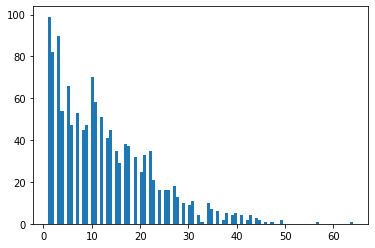

In [12]:
deg = [_[1] for _ in list(graph.degree)]
h = plt.hist(deg, bins=100)

## Louvain

In [12]:
partition = community.best_partition(graph, resolution=20, random_state=False)

In [13]:
# another way using another lib

import sknetwork as skn
louvain = skn.clustering.Louvain('python', resolution=30, random_state=None)
nodes_list = sorted(list(graph.nodes()))
louvain.fit(nx.adj_matrix(graph, nodes_list))
partition = dict(zip(nodes_list, louvain.labels_))

In [17]:
def stats_threshold(stats, threshold=7.9):
    stats['g'] = stats.max_raiting.apply(lambda v: 1 if v >= threshold else 0)
    stats_g = stats.groupby(['g']).agg({'title': 'sum', 'win_movies':'sum', 'win_and_nominated_movies': 'sum', 
                                        'max_raiting':'max', 'min_raiting': 'min', 'averageRating': 'mean'})
    return stats_g

In [18]:
def precision_recall(stats_g):
    stats_g = stats_g.copy()
    total_win = stats_g.win_movies.sum()
    total_win_and_nom = stats_g.win_and_nominated_movies.sum()
    stats_g['win_precision'] = 100 * stats_g.win_movies / stats_g.title 
    stats_g['win_recall'] = 100 * stats_g.win_movies / total_win 
    stats_g['win_nom_precision'] = 100 * stats_g.win_and_nominated_movies / stats_g.title
    stats_g['win_nom_recall'] = 100 * stats_g.win_and_nominated_movies / total_win_and_nom 
    return stats_g

In [103]:
stats = community_stats(df, partition)
stats_g = stats_threshold(stats, 7.9)
precision_recall(stats_g)

,title,win_movies,win_and_nominated_movies,max_raiting,min_raiting,averageRating,win_precision,win_recall,win_nom_precision,win_nom_recall
g,,,,,,,,,,
0,932,26,95,7.899873,5.0,6.443143,2.789700,40.0,10.193133,56.886228
1,389,39,72,8.902625,5.0,7.100399,10.025707,60.0,18.508997,43.113772


In [20]:
in_1 = [k for k in df.title.values if partition.get(k) in stats[stats.g == 1].community.values]
display(len(in_1))
graph_in_1 = get_graph_of_components(edges, in_1)

389

In [21]:
stats[stats.title >= 0].sort_values('win_movies')

,community,title,averageRating,stdRating,win,win_movies,win_and_nominated_movies,max_raiting,min_raiting,movie,tv_show,g
0,0.0,20,6.148992,0.939511,0.0,0,0,8.225518,5.200000,20,0,1
117,117.0,5,5.833039,0.614316,0.0,0,0,6.622524,5.300000,5,0,0
121,121.0,5,6.813732,0.975208,0.0,0,1,7.708018,5.396245,5,0,0
124,124.0,5,7.100000,0.764853,0.0,0,0,8.000000,6.100000,5,0,1
126,126.0,5,6.039968,1.045400,0.0,0,0,7.499983,5.200092,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
120,120.0,5,7.534985,0.402998,5.0,2,4,7.999971,6.900000,5,0,1
8,8.0,12,6.192584,1.004778,5.0,2,2,8.000000,5.000000,12,0,1
102,102.0,6,7.433114,0.950224,3.0,2,3,8.300501,5.700000,6,0,1
150,150.0,5,7.073855,0.296692,2.0,2,2,7.400000,6.669276,5,0,0


## Hypothesis Testing

,N,Mean,SD,SE,95% Conf.,Interval
g,,,,,,
0,932,6.405297,0.712946,0.023353,6.359500,6.451094
1,389,6.924327,0.993175,0.050356,6.825502,7.023152


LeveneResult(statistic=19.499588335639697, pvalue=1.6536743637131594e-05)

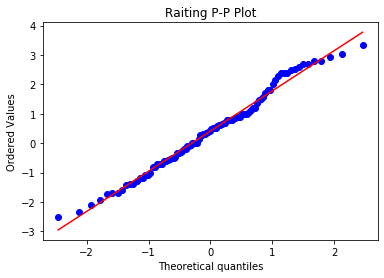

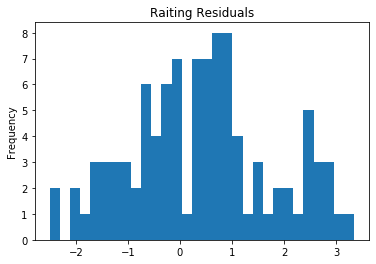

'Shapiro on diff:'

(0.9839091300964355, 0.26428964734077454)

Ttest_indResult(statistic=-3.148738570761908, pvalue=0.0019213172912959872)

In [206]:
title_and_community = pd.DataFrame(partition.items(), columns=['title', 'community'])\
                        .merge(stats[['community', 'g']], on=['community'])\
                        .merge(df, on=['title'])
title_and_community.win = title_and_community.win.apply(lambda v: v if v > 1 else 0)
col = 'averageRating'
summ = rp.summary_cont(title_and_community.groupby(['g'])[col])
display(summ)
g0 = title_and_community[title_and_community.g == 0].sample(n=100)
g0.reset_index(inplace=True)
g1 = title_and_community[title_and_community.g == 1].sample(n=100)
g1.reset_index(inplace=True)

levene_homogenity = scipy.stats.levene(g0[col], g1[col])
display(levene_homogenity)
diff = g1[col] - g0[col]
scipy.stats.probplot(diff, plot= plt)
plt.title('Raiting P-P Plot') 
plt.show()
diff.plot(kind= "hist", title= "Raiting Residuals", bins=30)
plt.show()
display('Shapiro on diff:', scipy.stats.shapiro(diff))
display(scipy.stats.ttest_ind(g0[col], g1[col], equal_var=False))

## Hierarhy Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
sc = AgglomerativeClustering(50, 'l2', linkage='complete')
nodes_list = sorted(graph_in_1.nodes())
adj_mat = nx.to_numpy_matrix(graph_in_1, nodes_list)
lables = list(zip(nodes_list, sc.fit_predict(adj_mat)))

scdf = pd.DataFrame(lables, columns=['title', 'cluster'])
stats = community_stats(df[df.title.isin(in_1)], dict(lables))
stats_g = stats_threshold(stats)
precision_recall(stats_g)

/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


,title,win_movies,win_and_nominated_movies,max_raiting,min_raiting,averageRating,win_precision,win_recall,win_nom_precision,win_nom_recall
g,,,,,,,,,,
0,34,1,4,7.600000,5.2,6.602447,2.941176,2.564103,11.764706,5.555556
1,355,38,68,8.902625,5.0,7.898179,10.704225,97.435897,19.154930,94.444444


## Spectracl Clustering

In [210]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(100)
nodes_list = sorted(graph_in_1.nodes())
adj_mat = nx.to_numpy_matrix(graph_in_1, nodes_list)
lables = list(zip(nodes_list, sc.fit_predict(adj_mat)))

scdf = pd.DataFrame(lables, columns=['title', 'cluster'])
stats = community_stats(df[df.title.isin(in_1)], dict(lables))
stats_g = stats_threshold(stats)
precision_recall(stats_g)

/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:482: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


,title,win_movies,win_and_nominated_movies,max_raiting,min_raiting,averageRating,win_precision,win_recall,win_nom_precision,win_nom_recall
g,,,,,,,,,,
0,3,2,3,7.300000,6.8,7.000000,66.666667,4.255319,100.000000,3.225806
1,477,45,90,8.902625,4.3,6.806188,9.433962,95.744681,18.867925,96.774194


## TSNE

In [183]:
from sklearn import manifold
items = sorted(graph.nodes())
g_edges = [k for k, v in partition.items()]# if v in stats[stats['g'] == 1].community.values]
only_comp_edges_ = [(items.index(i), items.index(j), 1/w) for (i, j, w) in edges.values if i in g_edges and j in g_edges]

In [184]:
gg = nx.Graph()
gg.add_weighted_edges_from(only_comp_edges_)

In [241]:
mds = manifold.MDS(2, metric=True )
mat = nx.adj_matrix(gg, nodelist=items)
trs = mds.fit_transform(nx.adj_matrix(gg).toarray())

/home/rotem/Documents/code/ml-env/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


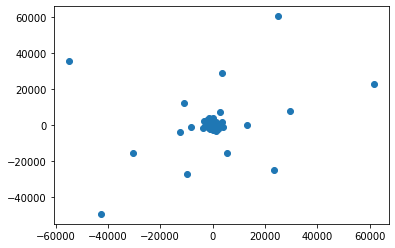

In [242]:
plt.scatter([_[0] for _ in trs], [_[1] for _ in trs])

In [235]:
from sklearn.cluster import KMeans
kmeans = KMeans(8)
pred = kmeans.fit_predict(trs)

In [191]:
from sklearn.mixture import GaussianMixture
kmeans = GaussianMixture(3)
pred = kmeans.fit_predict(trs)

In [251]:
from sklearn.cluster import DBSCAN
kmeans = DBSCAN(3000)
pred = kmeans.fit_predict(trs)

In [222]:
pred = []
for t in trs:
    if -200 <= t[0] <= 150 and -200 <= t[1] <= 200:
        pred.append(1)
    else:
        pred.append(0)

,community,title,averageRating,stdRating,win,win_movies,win_and_nominated_movies,max_raiting,min_raiting,movie,tv_show,win_precision,win_recall,win_nom_precision,win_nom_recall
1,0.0,1306,6.555975,0.839158,125.0,61,163,8.902625,5.000000,1306,0,4.670750,93.846154,12.480858,97.60479
0,-1.0,15,6.746479,0.860832,7.0,4,4,7.900000,5.102411,15,0,26.666667,6.153846,26.666667,2.39521


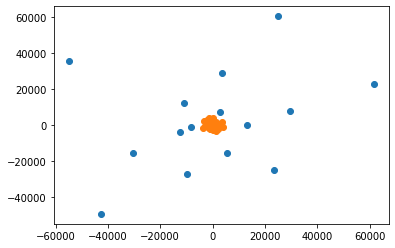

In [252]:
trs_pred = pd.DataFrame(zip(items, trs, pred), columns=['title', 'xy', 'cluster'] )
# plt.scatter([_[0] for _ in e], [_[1] for _ in e])
trs_pred_g = trs_pred.groupby(['cluster'])
trs_pred_g.xy = trs_pred_g.xy.apply(list)
for v in trs_pred_g.xy.values:
    plt.scatter([_[0] for _ in v], [_[1] for _ in v])
precision_recall(community_stats(df, dict(trs_pred[['title', 'cluster']].values)))

In [244]:
trs_pred['dist'] = trs_pred.xy.apply(lambda c: sqrt(sum(c ** 2)))
trs_pred = trs_pred.merge(df, on=['title'])
trs_pred.win = trs_pred.win.apply(lambda v: 1 if v > 1 else 0)
trs_pred[['dist', 'win']]
trs_pred[['dist', 'win', 'averageRating']].corr()

,dist,win,averageRating
dist,1.000000,0.124685,0.029833
win,0.124685,1.000000,0.231998
averageRating,0.029833,0.231998,1.000000


## Girvan Newman

In [93]:
gn = nx.algorithms.community.centrality.girvan_newman(graph)

In [98]:
for i in range(200):
    gn0 = next(gn)

KeyboardInterrupt: 

In [100]:
gnp = {}
for i, arr in enumerate(gn0):
    for item in arr:
        gnp[item] = i
stats = community_stats(df, gnp)
stats['g'] = stats.max_raiting.apply(lambda v: 1 if v >= 8 else 0)
stats_g = stats.groupby(['g']).agg({'title': 'sum', 'win_movies':'sum', 'max_raiting':'max', 'min_raiting': 'min', 'averageRating': 'mean'})
stats_g['rate'] = 100 * stats_g.win_movies / stats_g.title 
stats_g

,title,win_movies,max_raiting,min_raiting,averageRating,rate
g,,,,,,
0,378,7,7.978913,5.0,6.399097,1.851852
1,943,51,8.902625,5.0,7.586273,5.408271


In [99]:
len(gn0)

222